In [3]:
import numpy as np 
import pylab as pl 
import glob
import os
from os.path import isfile,join
from os import listdir
import csv
import seaborn as sns
from astropy.stats import median_absolute_deviation, sigma_clip
import gc
import george
from george import kernels
import emcee
import scipy.optimize as op

george.__version__

%matplotlib inline 

In [4]:
sns.set_style("darkgrid", {"axes.facecolor": ".92"})
sns.set_palette(sns.color_palette("husl"))

In [5]:
root = "../data/"
all_files = glob.glob(os.path.join(root, "XRB/GBI/*"),recursive=True) 
allfiles = []
for path, subdirs, files in os.walk(root):
    #subdirs[:] = [d for d in subdirs if d not in ['GBI']]
    for filename in files:
        f = os.path.join(path, filename)
        allfiles.append(f)
    

# George 


In [6]:
def get_sigma_clipped_fluxes(raw_fluxes):
    """
    Uses the astropy sigma_clip function to try and get rid of outliers.

    ( https://astropy.readthedocs.org/en/stable/api/astropy.stats.sigma_clip.html )

    Returns a masked array where all outlier values are masked.
    """

    # First we try to run sigma clip with the defaults - hopefully this will
    # iterate until it converges:
    clipped_fluxes = sigma_clip(raw_fluxes, iters=None,
                                stdfunc=median_absolute_deviation)
    # If it fails (number of unmasked values <3),
    # then we just accept the result from a single iteration:
    if len(clipped_fluxes.compressed()) < 3:
        logger.warning("Sigma clipping did not converge, "
                       "using single iteration")
        clipped_fluxes = sigma_clip(raw_fluxes, iters=1,
                                    stdfunc=median_absolute_deviation)
    return clipped_fluxes

def loadfile(file):
    if "GBI" in file:
        data = np.loadtxt(file)
        x,y,err = data[:,0],data[:,3],data[:,6]
        y_eq_minus1 = np.where(y == -1)
        y = np.delete(y,y_eq_minus1)
        x = np.delete(x,y_eq_minus1)
        err =  np.delete(err,y_eq_minus1)

    else:
        data = np.loadtxt(file)
        x,y,err = data[:,0],data[:,1],data[:,2]

    return x,y,err

def get_ls(x,y,err):
    clipped_fluxes = get_sigma_clipped_fluxes(y)
    background = np.ma.median(clipped_fluxes)
    noise = median_absolute_deviation(clipped_fluxes)

    rise_threshold = background + 5 * noise
    fall_threshold = background #+ 1 * noise 
    flux_plus_err = y + err
    
    trigger = np.where(flux_plus_err > rise_threshold)[0]
    if len(trigger) == 0: 
        trigger = np.where(flux_plus_err == np.max(flux_plus_err))[0][0]
    else: 
        trigger = trigger[0]

    indexes = np.where(y < fall_threshold)[0]
    if len(indexes) == 0: 
        indexes = np.where(y < background)[0]
    
    fall_indexes = np.array([indexes[i] for i in range(len(indexes)-1) if y[indexes[i]] > y[indexes[i+1]]])

    fall = np.where(fall_indexes > trigger)[0]
    if len(fall) == 0:
        fall_idx = len(y) - 1
    else:
        fall_idx = fall_indexes[np.where(fall_indexes > trigger)][0]
        
    rise = np.where(indexes <= trigger)[0]
    if len(rise) == 0:
        rise_idx = trigger
    else: 
        rise_idx = indexes[np.where(indexes < trigger)][-1]
#     print('background - ', background)
#     print("noise - ", noise)
#     print("fall thresh - ",fall_threshold)
#     print('trigger - ',trigger)
#     print('rise/fall -',rise,fall_idx)
    return  ((x[fall_idx] - x[rise_idx]))/(2*np.sqrt(2*np.log(2)))

from george.modeling import Model

class PolynomialModel(Model):
    parameter_names = ("x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10")
       
    def get_value(self, t):
        t = t.flatten()
        return (self.x0 + self.x1*t + self.x2*(t**2) + self.x3*(t**3) + self.x4*(t**4) 
                + self.x5*(t**5) + self.x6*(t**6) + self.x7*(t**7) + self.x8*(t**8) 
                + self.x9*(t**9) + self.x10*(t**10))
    
    def set_vector(self, vector, include_frozen=False):
        """
        Set the parameter values to the given vector
        Args:
            vector (array[vector_size] or array[full_size]): The target
                parameter vector. This must be in the same order as
                ``parameter_names`` and it should only include frozen
                parameters if ``include_frozen`` is ``True``.
            include_frozen (Optional[bool]): Should the frozen parameters be
                included in the returned value? (default: ``False``)
        """
        v = self.parameter_vector
        if include_frozen:
            v[:] = vector
        else:
            v[self.unfrozen_mask] = vector
        self.parameter_vector = v
        self.dirty = True



In [7]:
def test(file,num):
    x,y,err = loadfile(file)
        
    filename = file[len(root):]
    
#     param = np.polyfit(x,y,10)
#     param = param[::-1]
#     #print(param)
#     pf = param[0] + param[1]*x + param[2]*(x**2) + param[3]*(x**3) + param[4]*(x**4) + param[5]*(x**5) + param[6]*(x**6) +  param[7]*(x**7) +  param[8]*(x**8) +  param[9]*(x**9) +  param[10]*(x**10) 
    
#     par = dict(x0 = param[0],x1 = param[1],x2 = param[2],x3 = param[3],x4 = param[4],x5 = param[5],x6 = param[6],x7 = param[7],x8 = param[8],x9 = param[9],x10 = param[10],)
#     truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
    clipped_fluxes = get_sigma_clipped_fluxes(y)
    background = np.ma.median(clipped_fluxes)
    ls = get_ls(x,y,err)
    #print(ls)
    k1 = np.var(y)* kernels.ExpSquaredKernel(ls**2)
    
    kernel = k1 

    gp = george.GP(kernel,fit_mean=True, white_noise=np.max(err)**2,fit_white_noise=True)
    gp.compute(x,err)
    
    
    
    # Define the objective function (negative log-likelihood in this case).
    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)

    results = op.minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like,method="L-BFGS-B", tol = 1e-3)
    #print(results)

    # Run the optimization routine.
    p0 = gp.get_parameter_vector()
#     results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B",options= {'maxiter' : 10, 'disp': True,'ftol': 2.220446049250313e-05})

    # Update the kernel and print the final log-likelihood.
    gp.set_parameter_vector(results.x)

    t = np.linspace(np.min(x), np.max(x), 500)
    mu, cov = gp.predict(y, t)
    xnew = np.linspace(np.min(x),np.max(x),20)
    ynew = gp.sample_conditional(y,xnew,2)

    std = np.sqrt(np.diag(cov))

    
    f, axarr = pl.subplots(2,figsize=(15,12), sharex=True)
    
    axarr[0].errorbar(x,y,err,fmt='kx')
    #axarr[0].plot(x,pf)
    axarr[0].set_title('Raw Data -' + filename)
    
    axarr[1].errorbar(x,y,err,fmt='kx')
    axarr[1].plot(t,mu)
    axarr[1].fill_between(t, mu - 2*np.sqrt(std**2), mu + 2*np.sqrt(std**2), color='blue', alpha=0.2)
    axarr[1].set_title('Deez Nuts')
    pl.savefig('test'+str(num)+'.png')
    pl.show()
    
#     pl.errorbar(x,y,err,fmt='kx')
#     pl.plot(t,mu)
#     pl.plot(xnew,ynew[0],'x')
#     pl.plot(xnew,ynew[1],'x')
#     pl.fill_between(t, mu - 2*np.sqrt(std**2), mu + 2*np.sqrt(std**2), color='blue', alpha=0.2)
#     pl.show()


32 ../data/AGN/GBI/2005+403


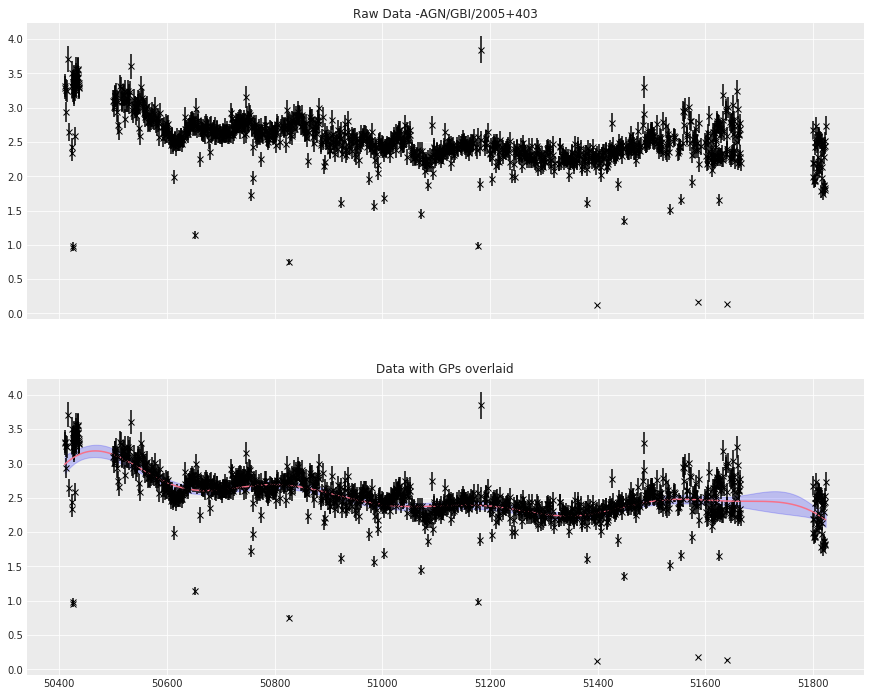

33 ../data/AGN/GBI/0850-121


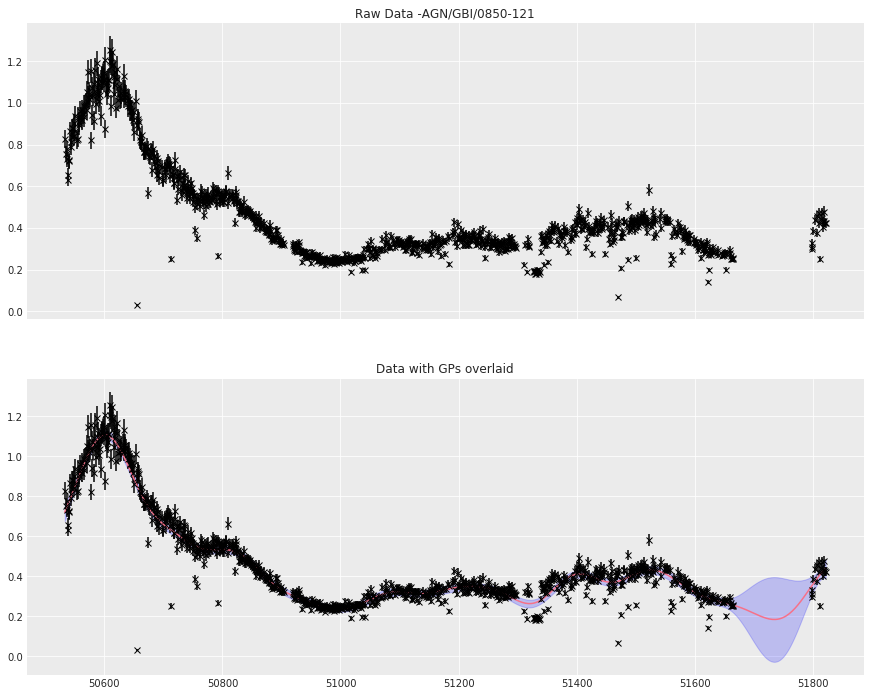

34 ../data/AGN/GBI/0336-019


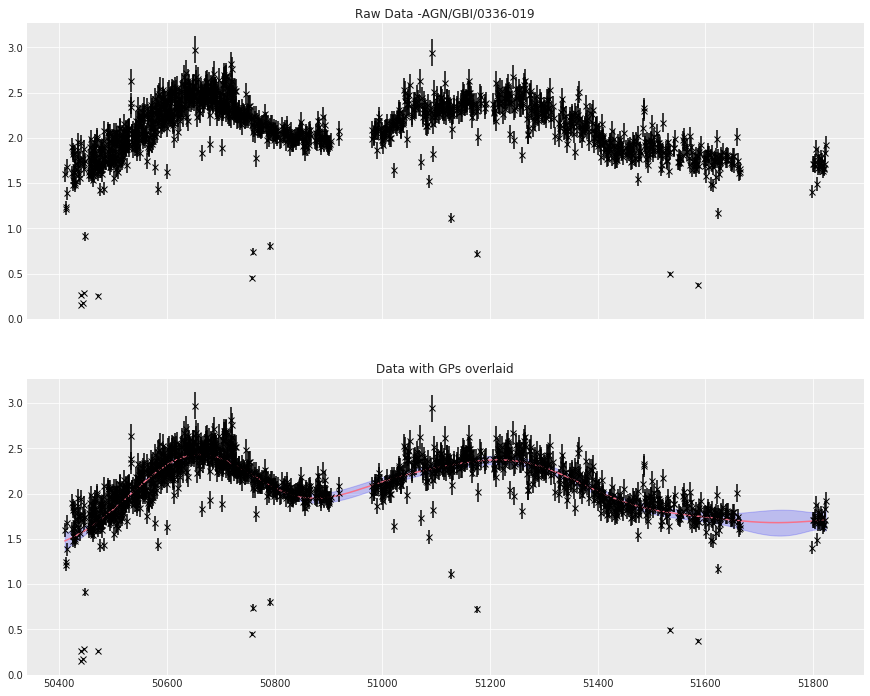

35 ../data/AGN/GBI/0528+134


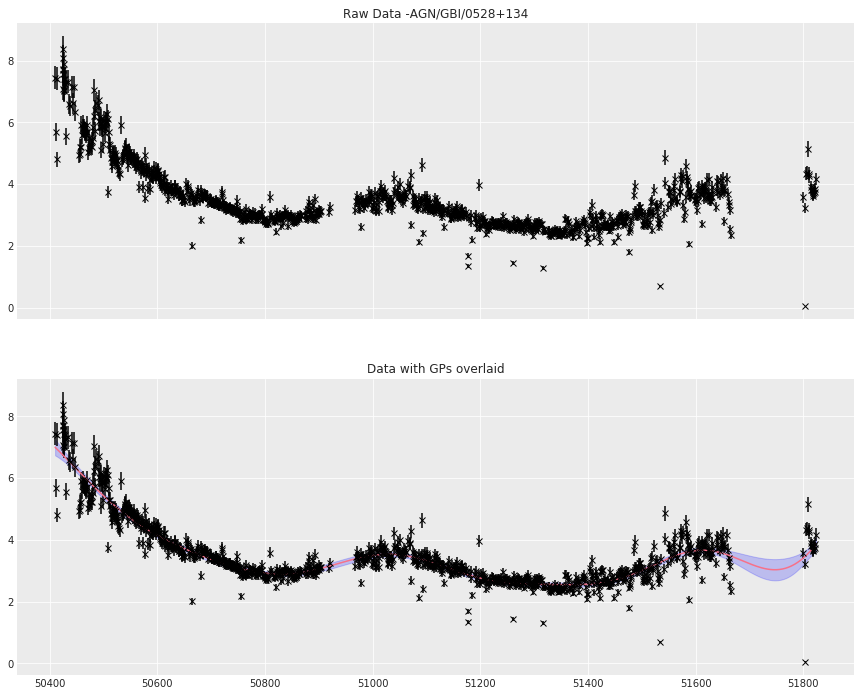

36 ../data/AGN/GBI/2200+420


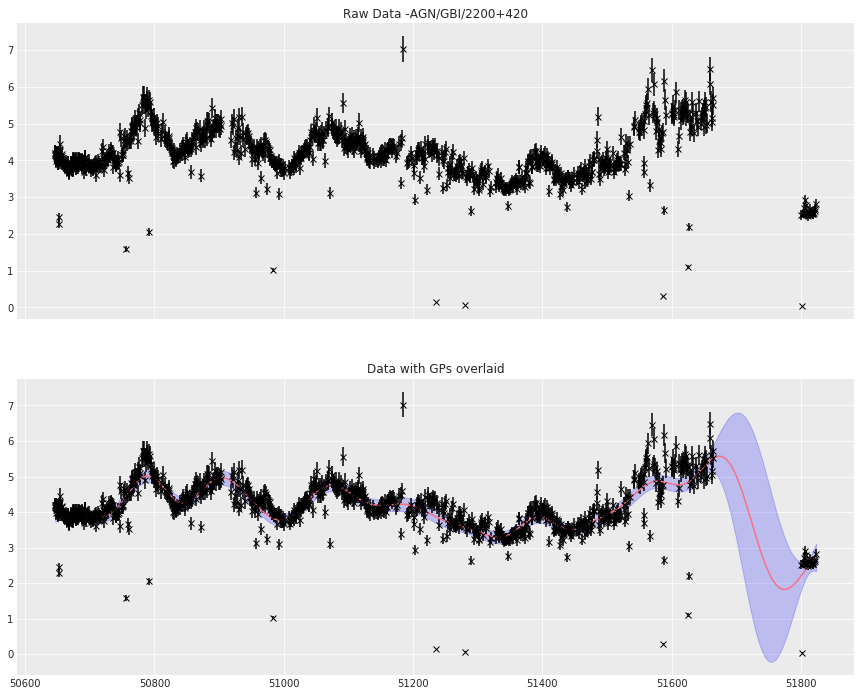

37 ../data/AGN/GBI/1237+049


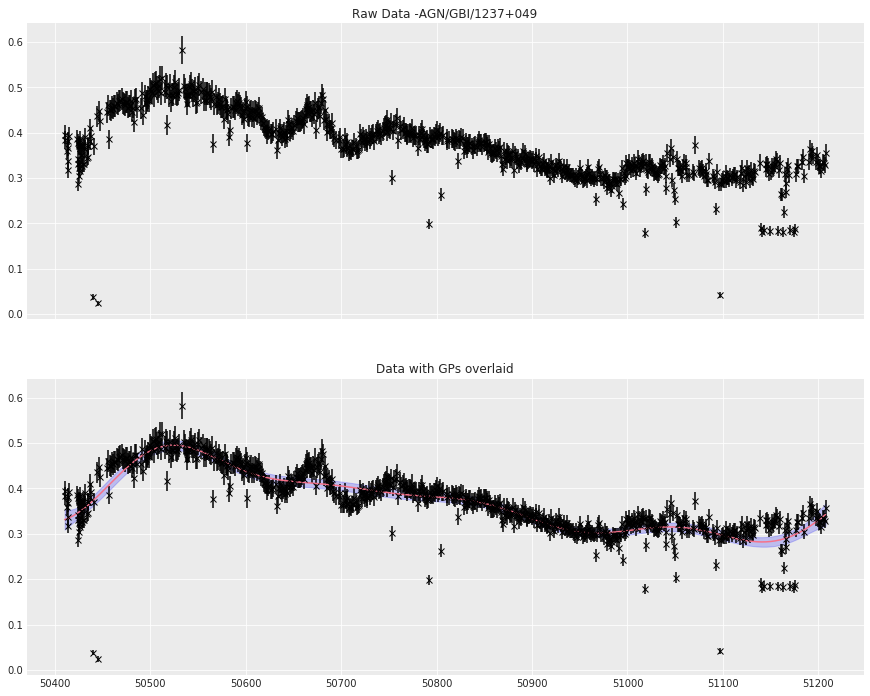

38 ../data/AGN/GBI/0954+658


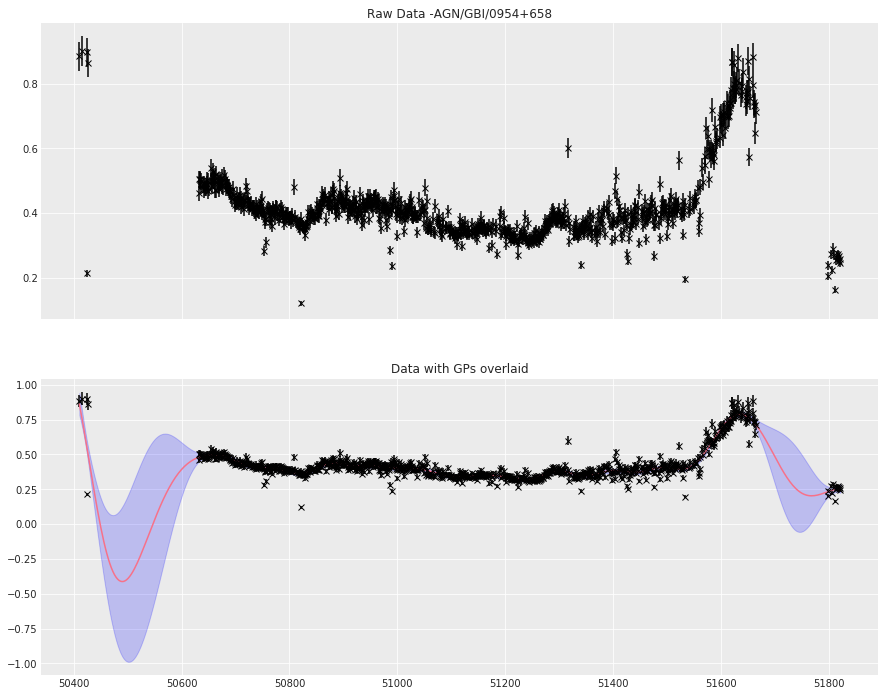

39 ../data/AGN/GBI/0851+202


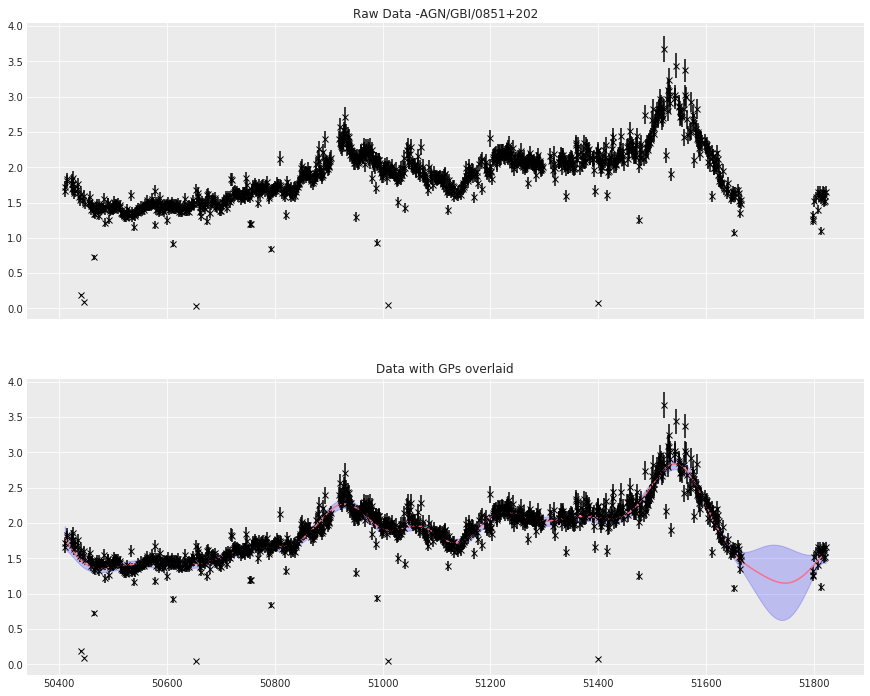

40 ../data/AGN/GBI/1749+096


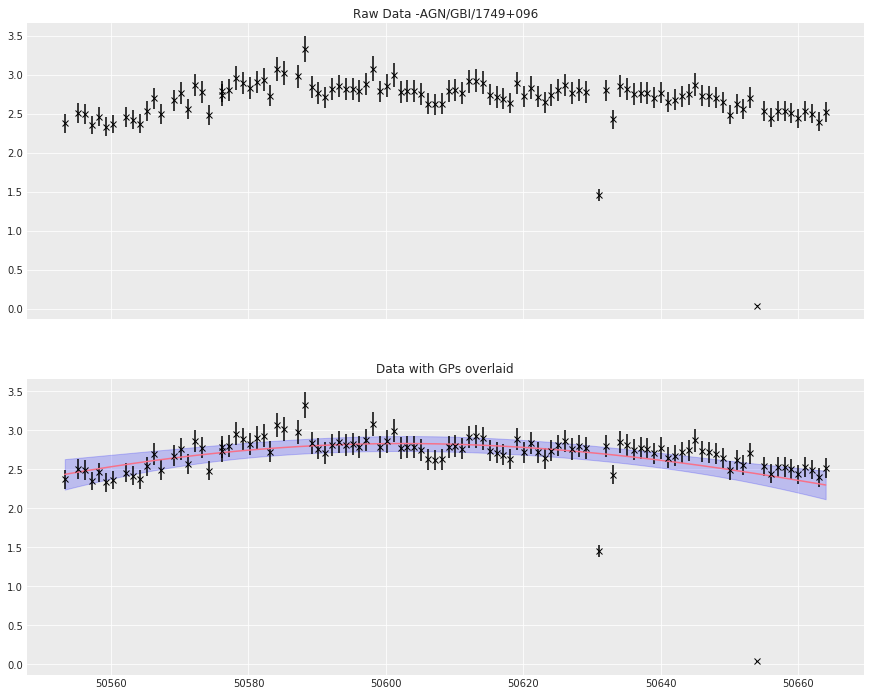

41 ../data/AGN/GBI/1413+135


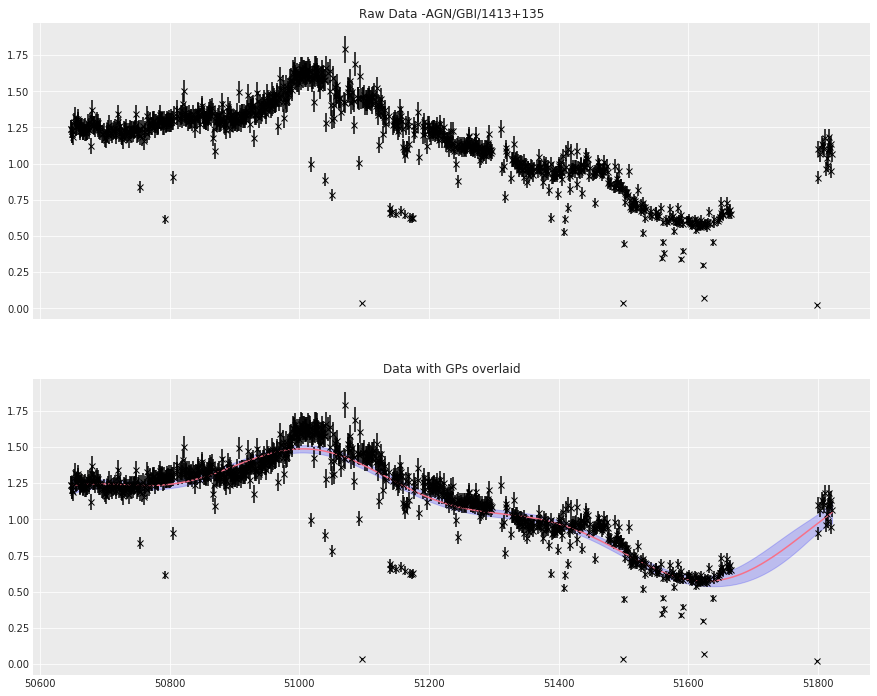

42 ../data/AGN/GBI/0224+671


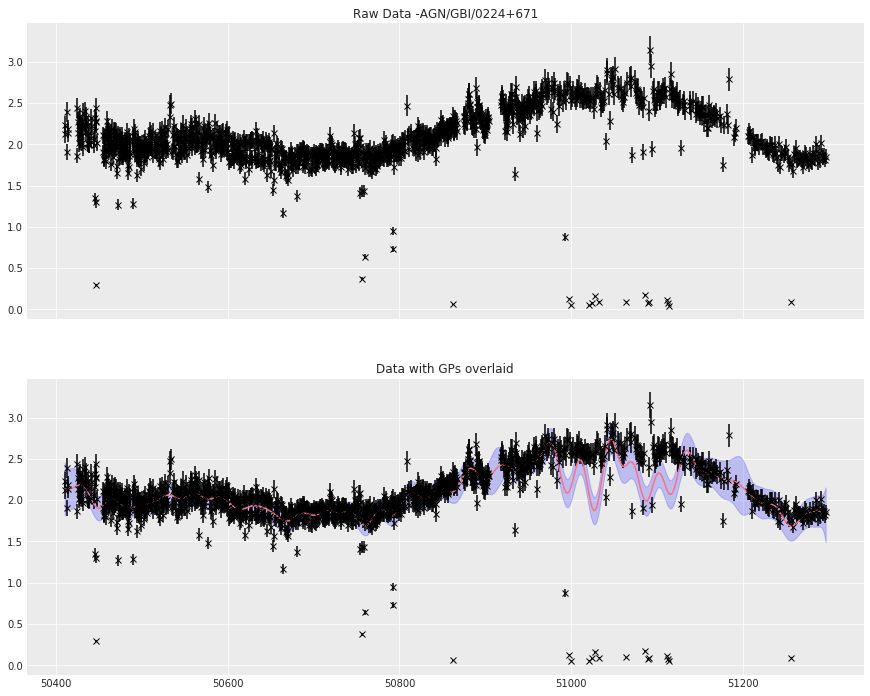

43 ../data/AGN/GBI/1622-297


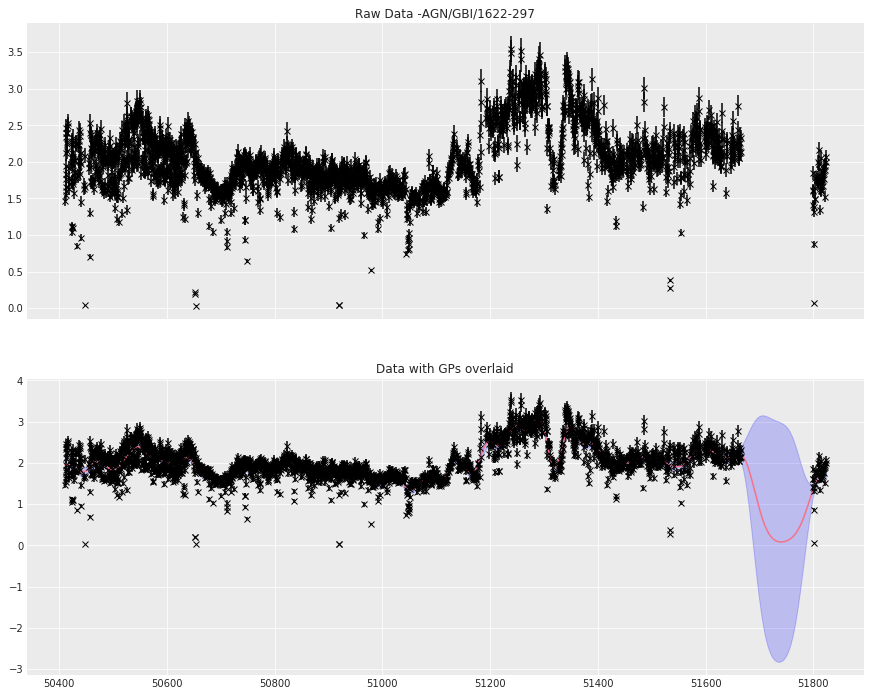

44 ../data/AGN/GBI/1328+254


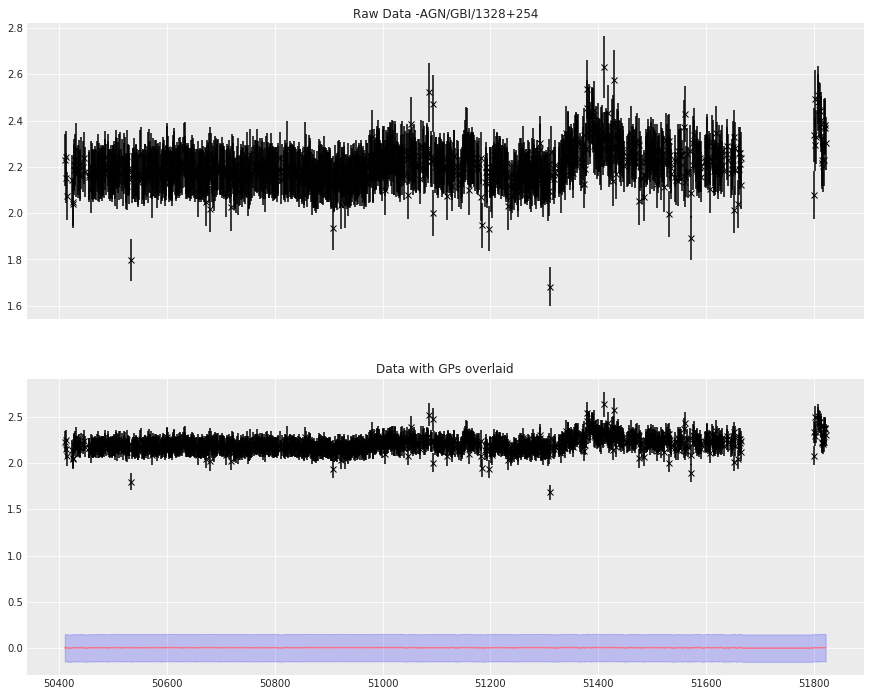

57 ../data/XRB/GBI/0236+610


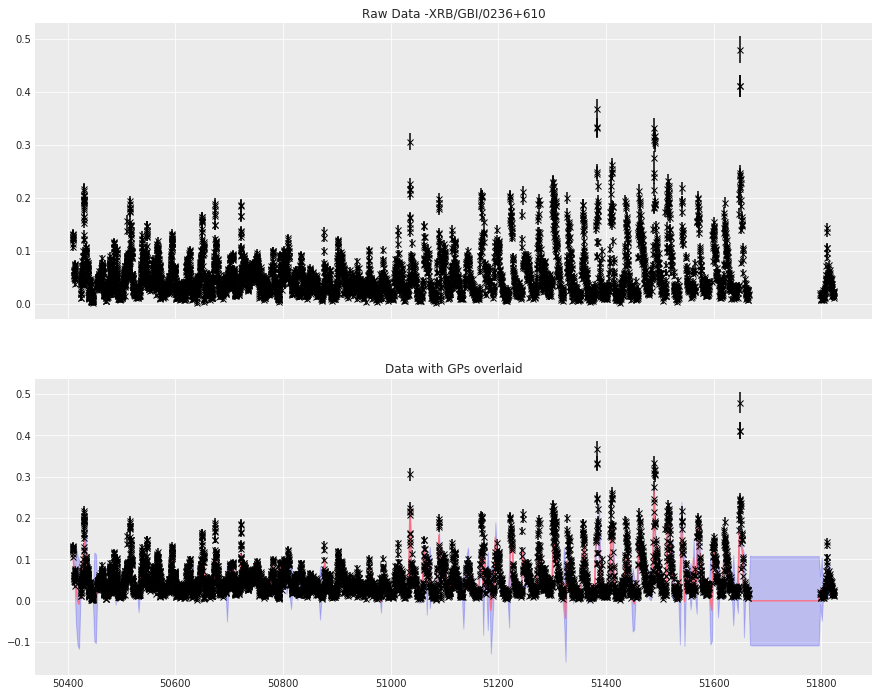

58 ../data/XRB/GBI/1909+048


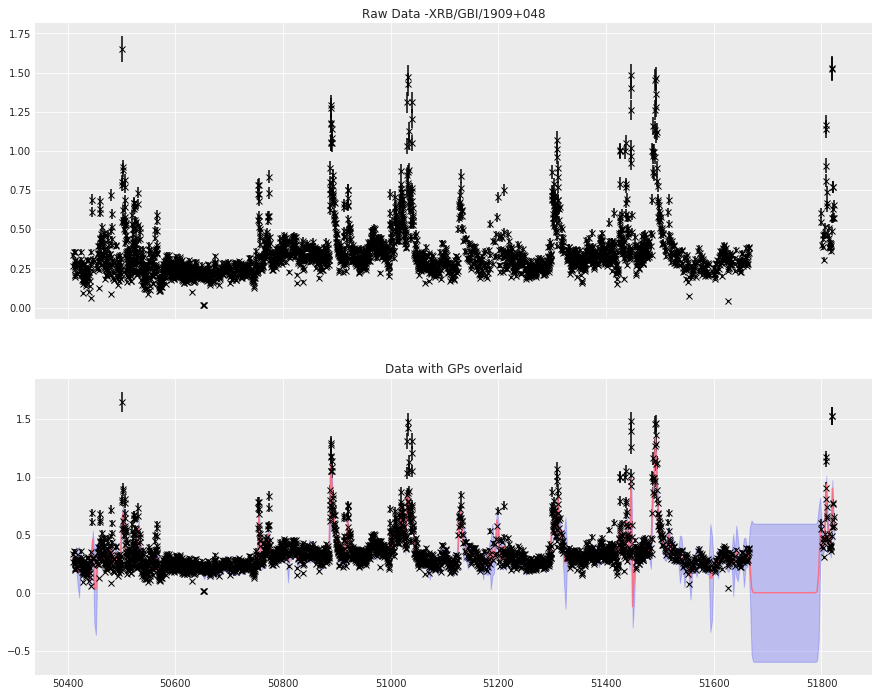

59 ../data/XRB/GBI/CygX-2


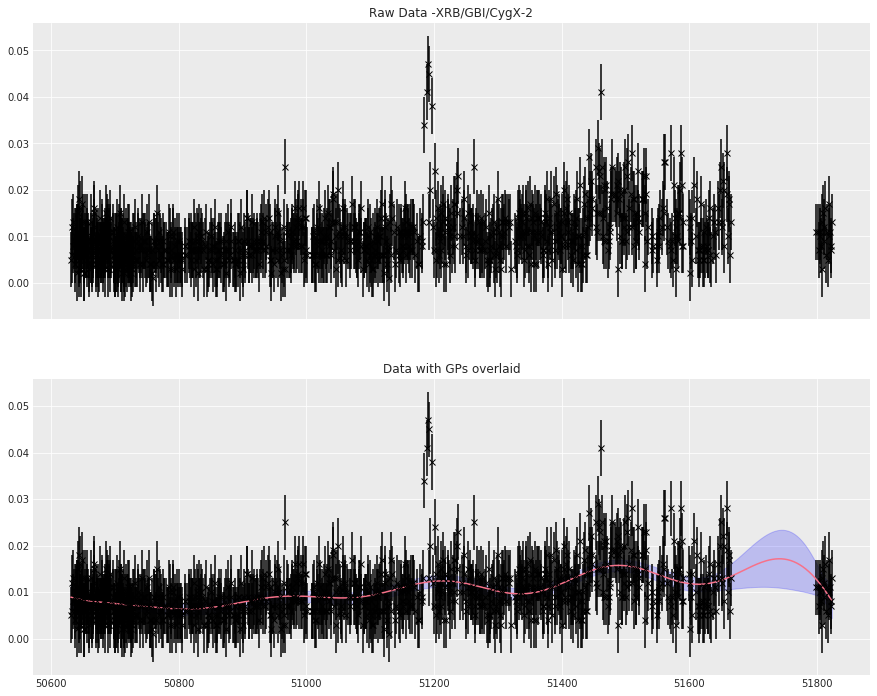

60 ../data/XRB/GBI/1915+105


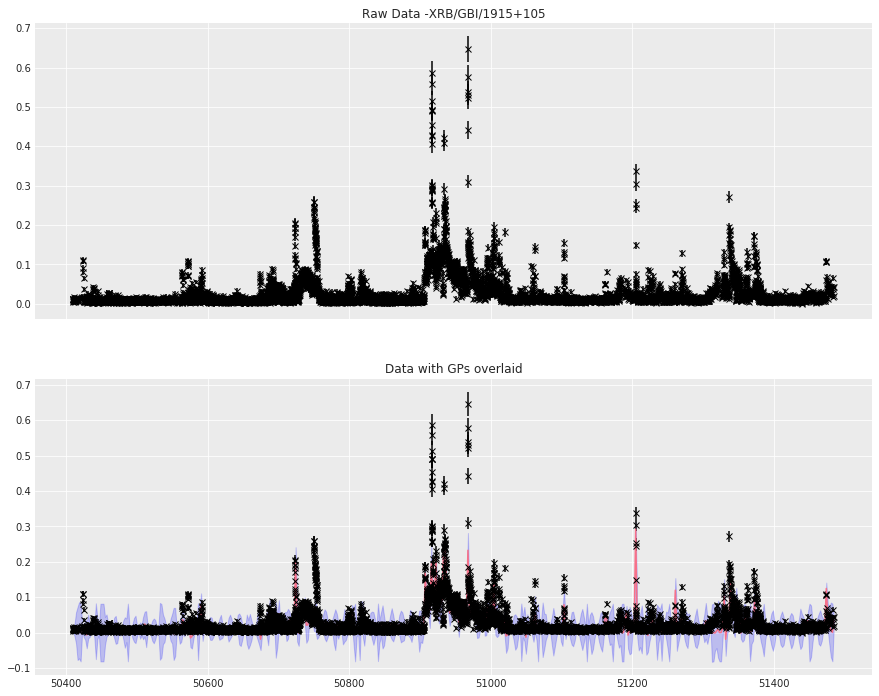

61 ../data/XRB/GBI/CygX-1


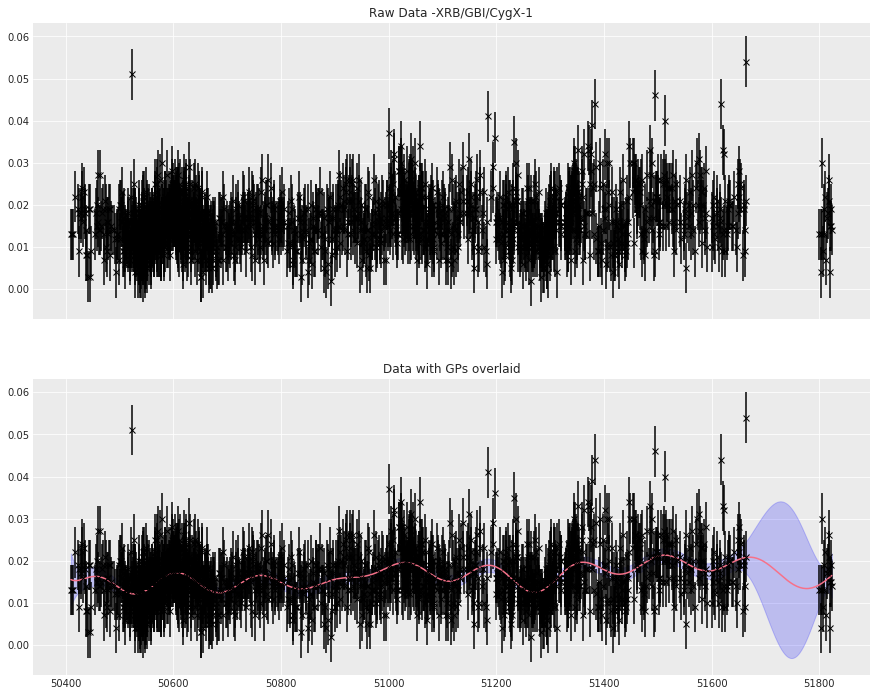

62 ../data/XRB/GBI/2030+407


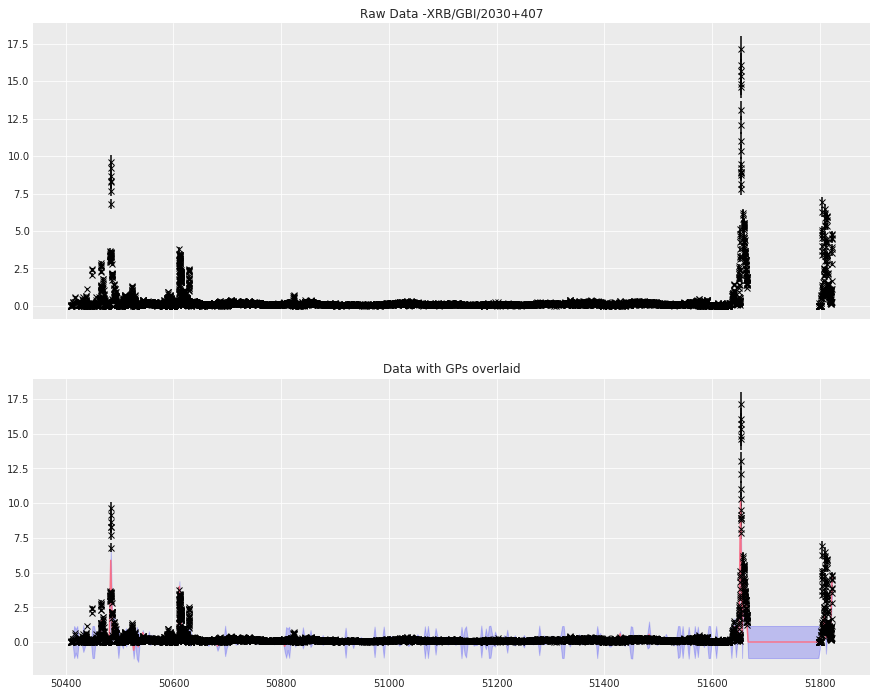

63 ../data/XRB/GBI/ScoX-1


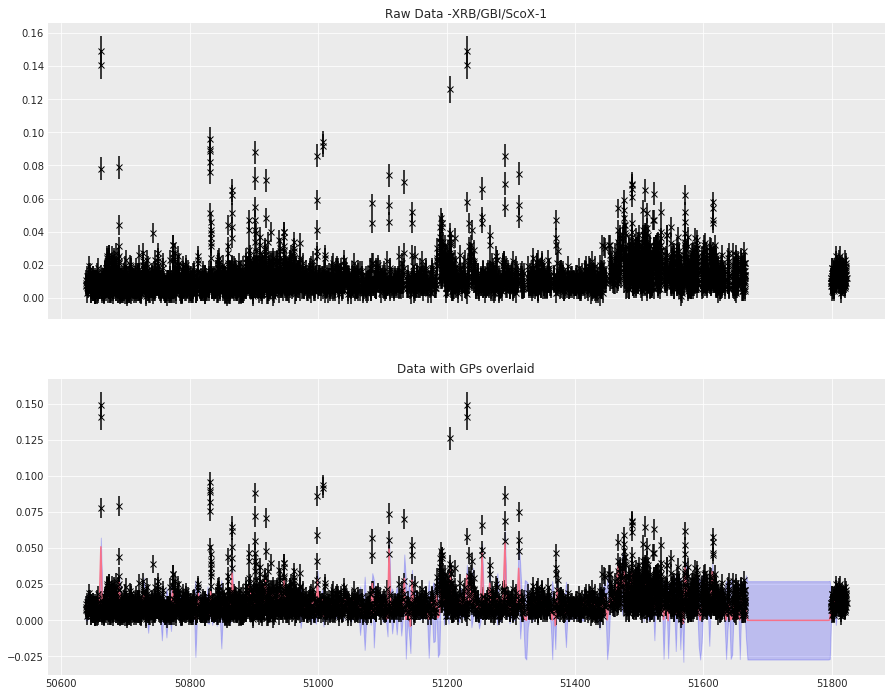

64 ../data/XRB/GBI/GX17+2


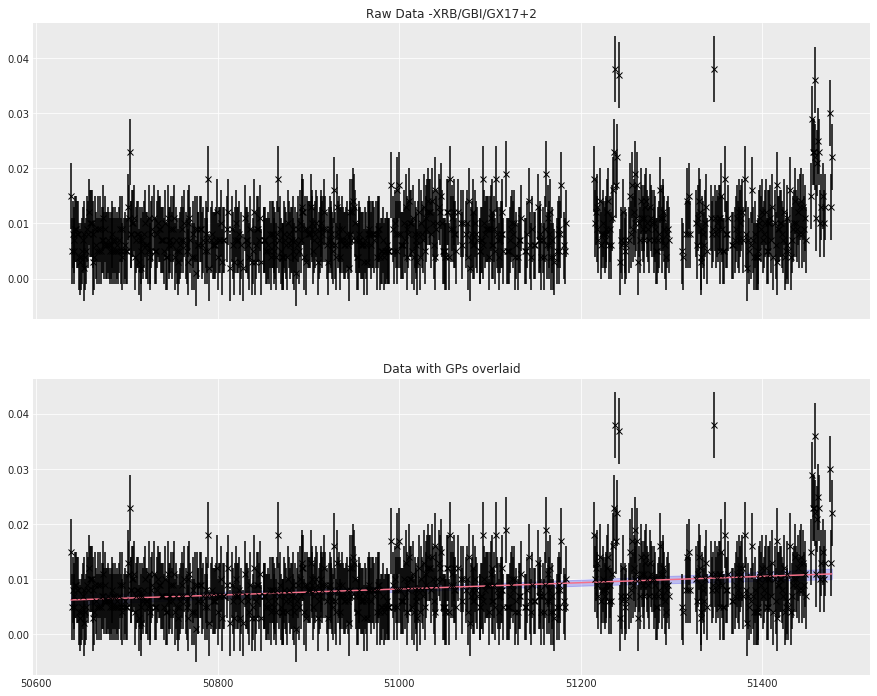

65 ../data/XRB/GBI/aqlX1


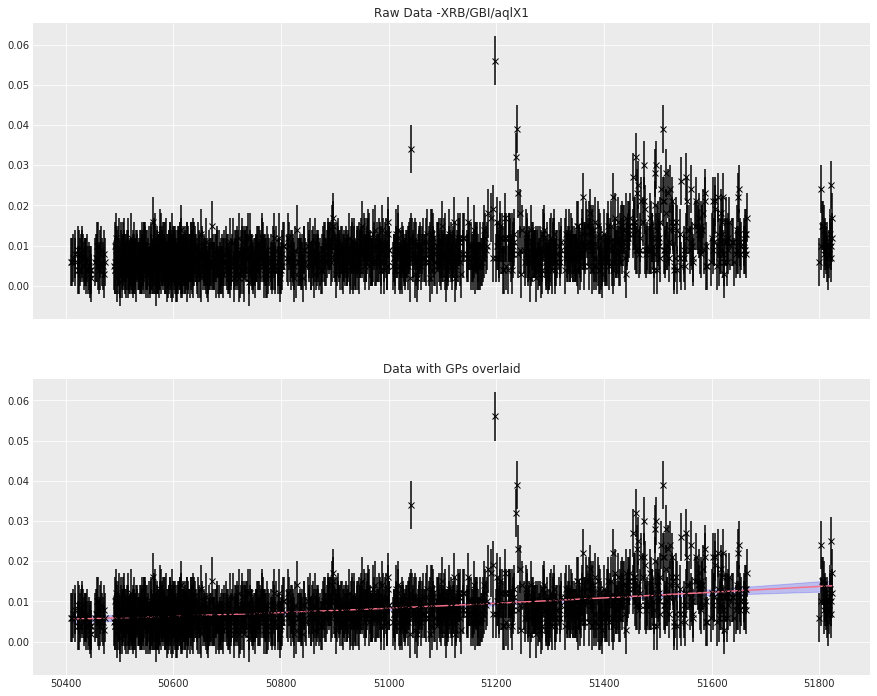

66 ../data/XRB/GBI/CICam


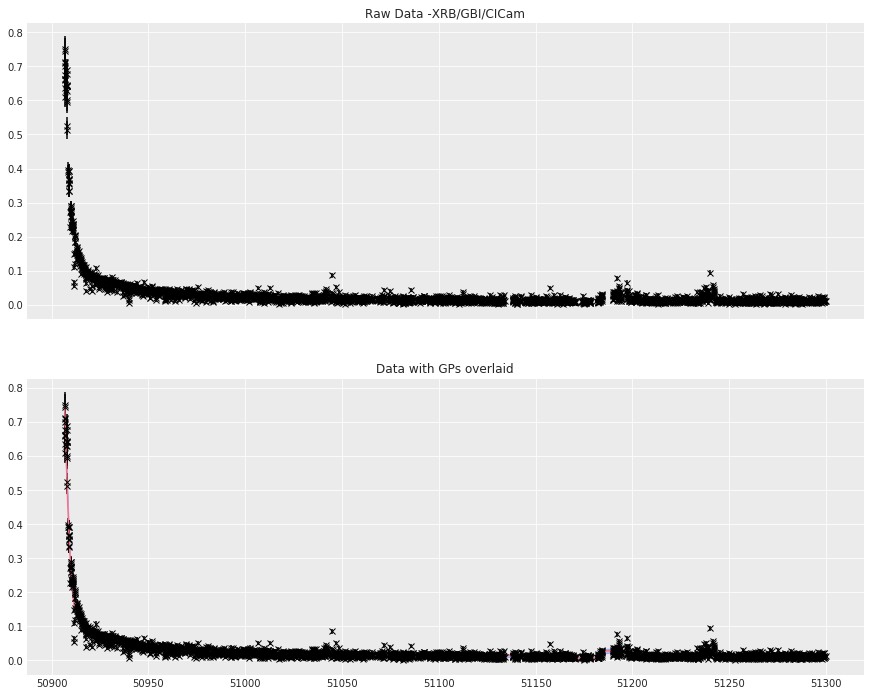

79 ../data/RSCVn/GBI/HR1099


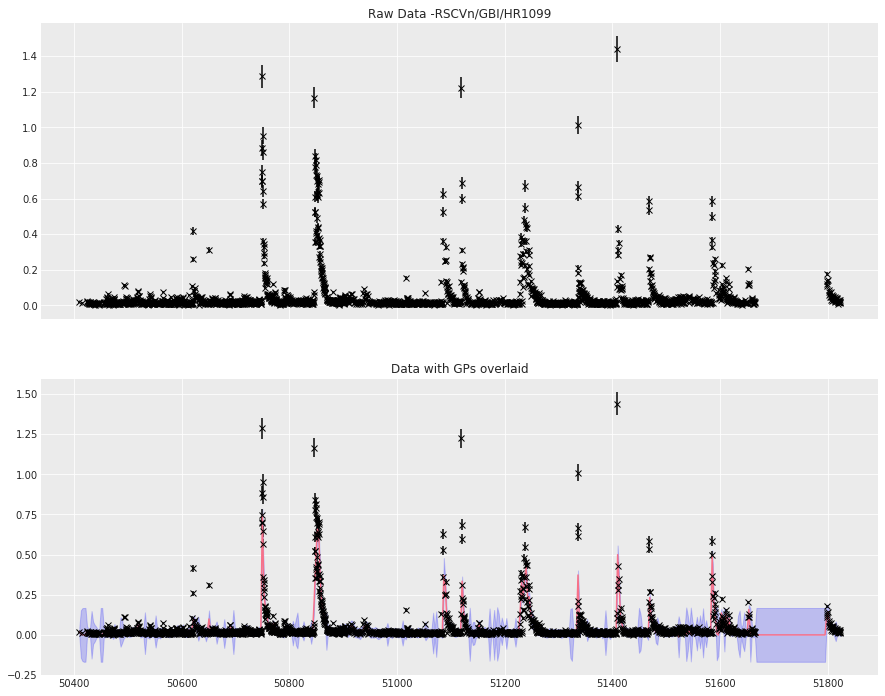

80 ../data/RSCVn/GBI/UXAri


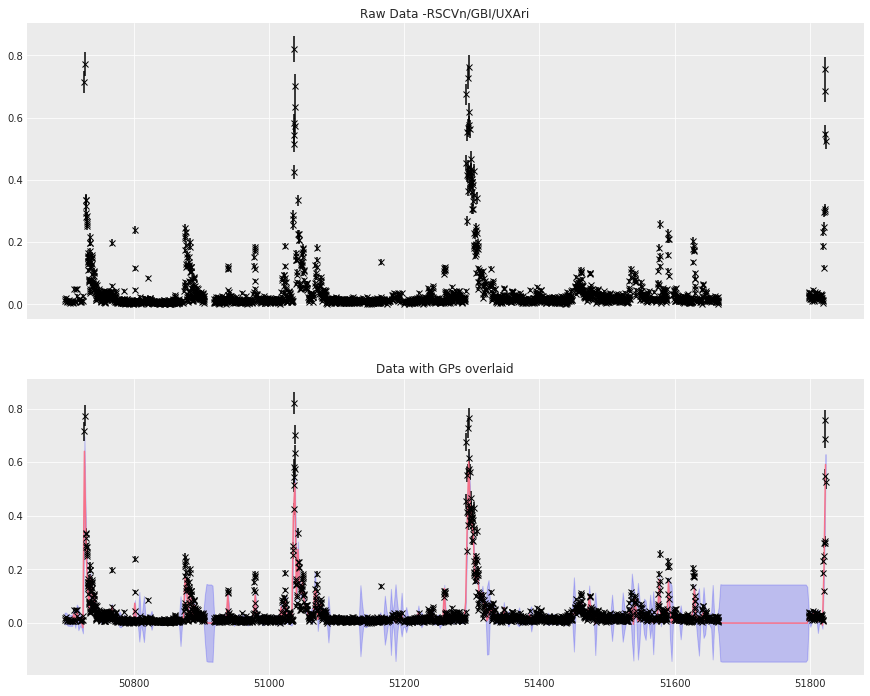

90 ../data/Algol/GBI/deltalib


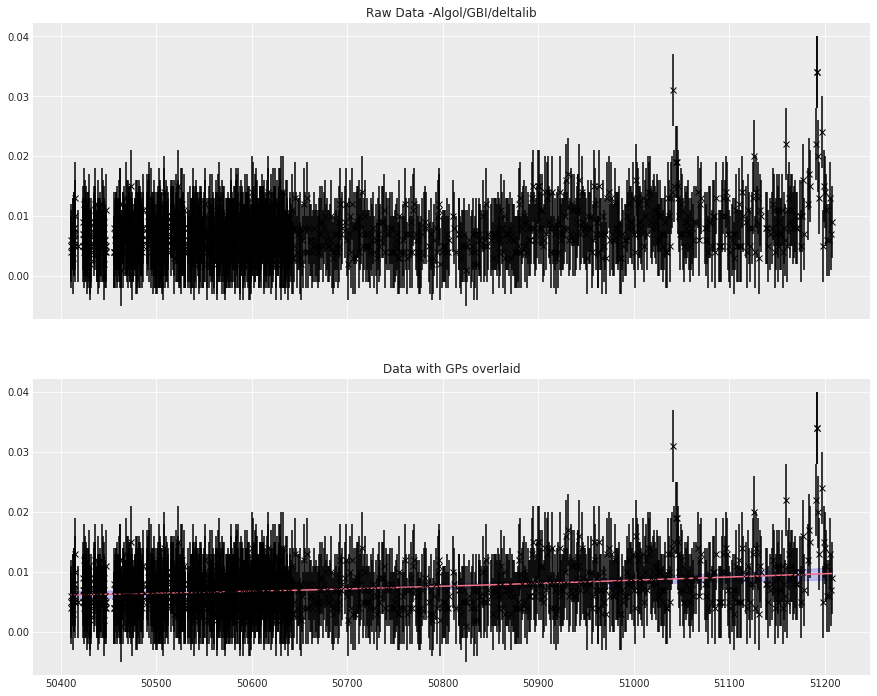

91 ../data/Algol/GBI/Algol


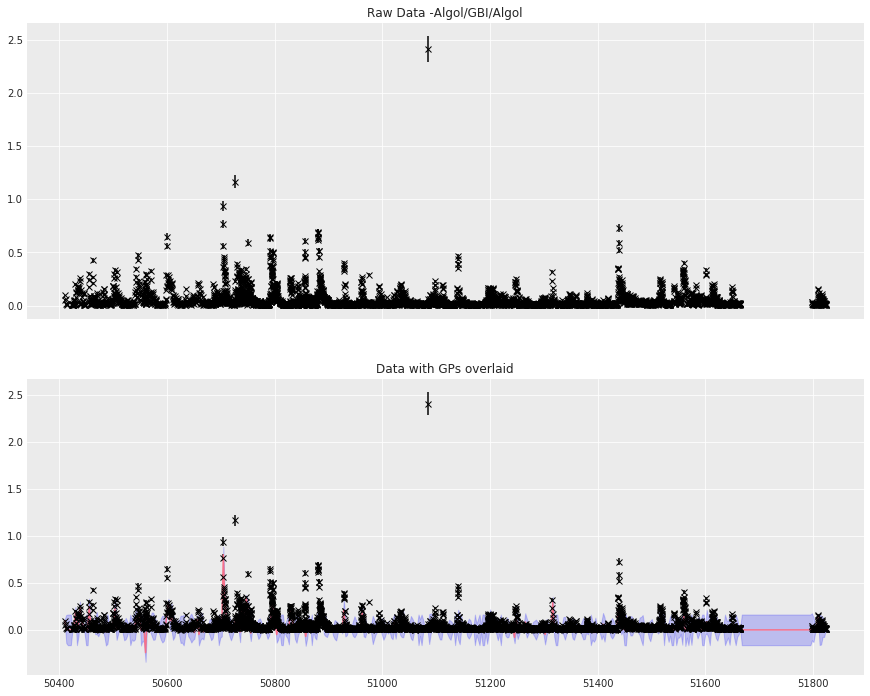

In [8]:
for i in range(len(allfiles)):
    file = allfiles[i]
    if "GBI"  in file:
        try:
            print(i,file)
            test(file,i)
        except Exception as e:
            print(file, e)

In [ ]:
for i in range(57,len(allfiles)):
    file = allfiles[i]
    #if "GBI" in file:
    try:
        print(i,file)
        test(file,i)
    except Exception as e:
        print(file, e)

In [ ]:
#11,18,19,24
num = 1
file = allfiles[num]
test(file,num)


In [ ]:
george.__version__